# Homework 5

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm import trange
import math

# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/7.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/4.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [279]:
def get_puzzle_images(path="puzzle/china_shuffle"):
    images_path = os.listdir(path)
    images = []
    for im in images_path:
        img = cv2.imread(os.path.join(path, im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        images.append(img)

    return np.array(images)

In [280]:
def crop(image):
    # left crop
    while not image[0].any():
        image = image[1:]
    # right crop
    while not image[-1].any():
        image = image[:-1]
    # top crop
    while not image[:, 0].any():
        image = image[:, 1:]
    # bottom crop
    while not image[:, -1].any():
        image = image[:, :-1]
    return image

In [281]:
def stitcher(img1, img2, match_number=20, best_match_number=5, angle_eps=2):
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

    if des2 is not None and des1 is not None:
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        if len(matches) > match_number:
            matches = matches[:best_match_number]
            list_kp1 = np.array([kp1[mat.queryIdx].pt for mat in matches])
            list_kp2 = np.array([kp2[mat.trainIdx].pt for mat in matches])
            x, y = list_kp1[:, 0] - list_kp2[:, 0], list_kp1[:, 1] - list_kp2[:, 1]
            angles = [math.degrees(math.atan2(y[elem], x[elem])) for elem in range(len(x))]

            if np.std(angles) < angle_eps:
                diff_x, diff_y = int(np.mean(x)), int(np.mean(y))
                img3 = np.zeros((max(img1.shape[0], abs(diff_y) + img2.shape[0], img1.shape[0] - diff_y),
                                 max((img1.shape[1], abs(diff_x) + img2.shape[1], img1.shape[1] - diff_x)), 3))
                diff_x1, diff_y1 = max(0, -diff_x), max(0, -diff_y)
                diff_x2, diff_y2 = max(0, diff_x), max(0, diff_y)

                img3[diff_y1:diff_y1 + img1.shape[0], diff_x1:diff_x1 + img1.shape[1]] = img1
                img3[diff_y2:diff_y2 + img2.shape[0], diff_x2:diff_x2 + img2.shape[1]] = img2
                return img3

In [365]:
def get_possible_stitched(images, initial_puzzle = None, iterations = 10, stitch_iterations = 150):
    res = initial_puzzle
    if res is None:
        res = np.zeros_like(images[0])
    for i in trange(iterations):
        cimages = images.copy()
        cur_res = None
        if initial_puzzle is not None:
            cur_res = initial_puzzle
        else:
            idx = np.random.randint(0, len(cimages))
            cur_res = images[idx]
            cimages = np.delete(cimages, idx, 0)
        count = 0

        for count in range(stitch_iterations):
            if len(cimages) < 1:
                break
            idx = np.random.randint(0, len(cimages))
            cur = stitcher(cur_res, cimages[idx])
            if cur is not None:
                cur_res = cur
                cimages = np.delete(cimages, idx, 0)
        if (res.shape[0] <= cur_res.shape[0] or res.shape[1] <= cur_res.shape[1]) and cv2.mean(res) <= cv2.mean(cur_res):
            res = cur_res
    return res

In [232]:
def draw(res):
    fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

    plt.imshow(crop(res.astype(np.uint8)))

    fig.tight_layout()
    plt.show()

In [214]:
path = 'puzzle/china_shuffle'
images = get_puzzle_images(path)

In [215]:
res = get_possible_stitched(images)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:32<00:00, 45.21s/it]


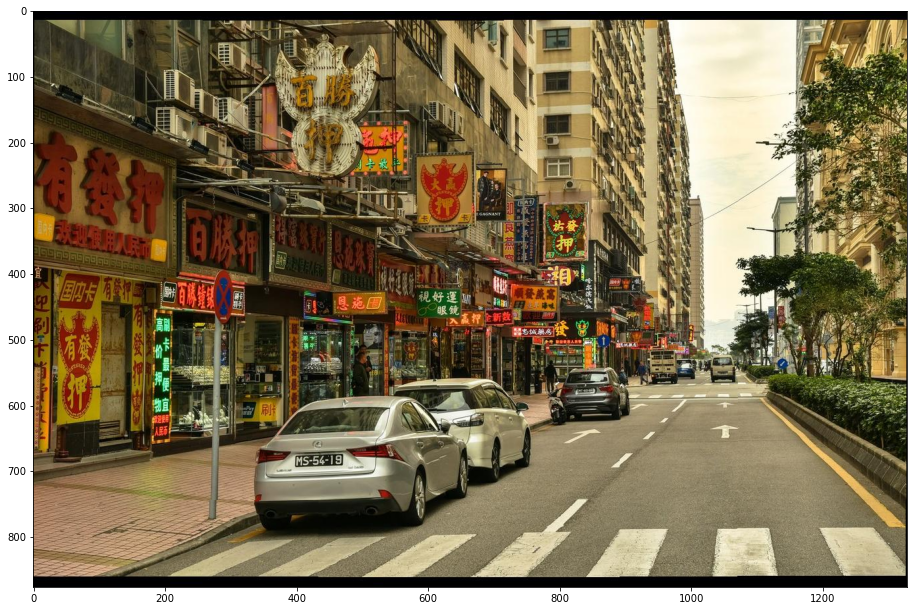

In [217]:
draw(res)

In [311]:
path = 'puzzle/su_fighter_shuffle'
images = get_puzzle_images(path)

In [312]:
res = get_possible_stitched(images, iterations = 5, stitch_iterations = 200)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


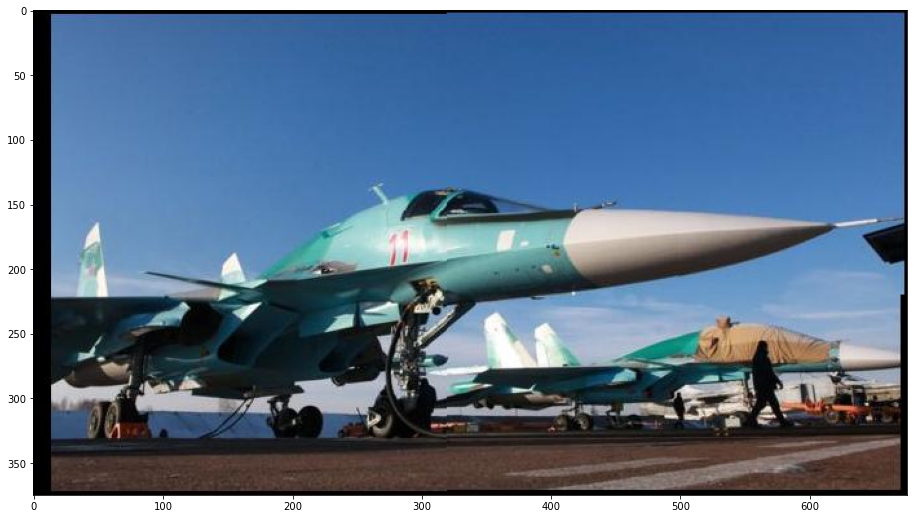

In [313]:
draw(res)

In [348]:
path = 'puzzle/home_shuffle'
images = get_puzzle_images(path)

In [349]:
res = get_possible_stitched(images, iterations = 3, stitch_iterations=150)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.76s/it]


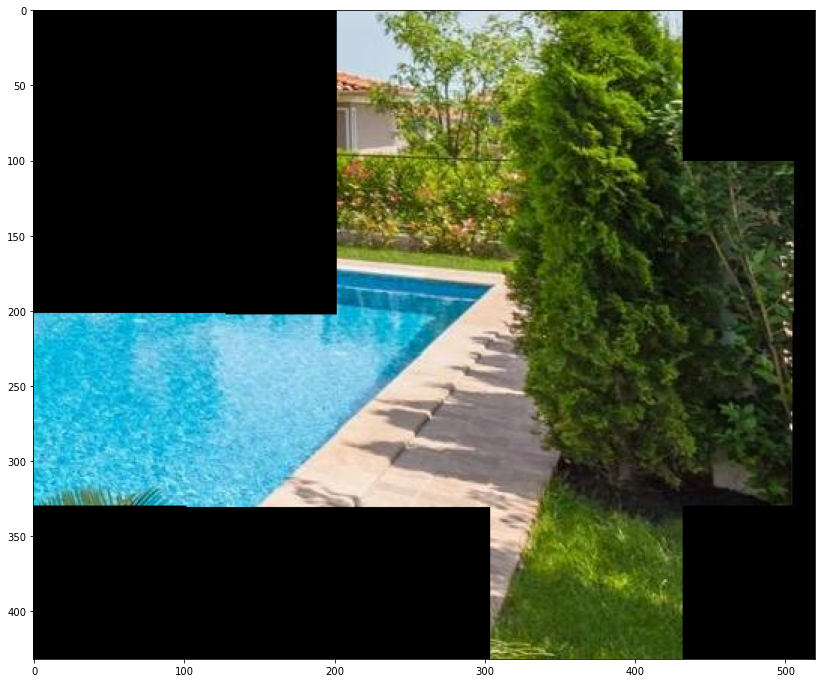

In [350]:
draw(res)

In [351]:
res_ = get_possible_stitched(images, initial_puzzle=res, iterations=10, stitch_iterations=500)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:25<00:00, 68.53s/it]


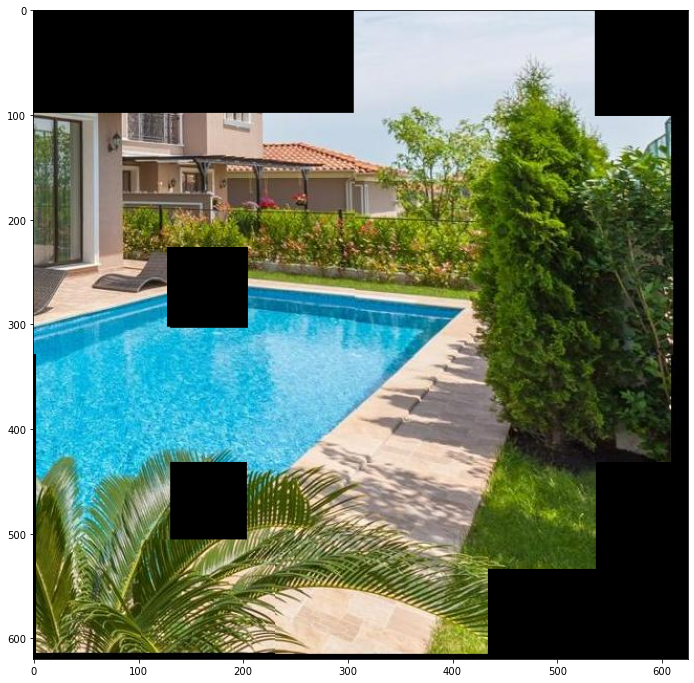

In [352]:
draw(res_)

In [357]:
res__ = get_possible_stitched(images, initial_puzzle=res_, iterations=1, stitch_iterations=300)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.93s/it]


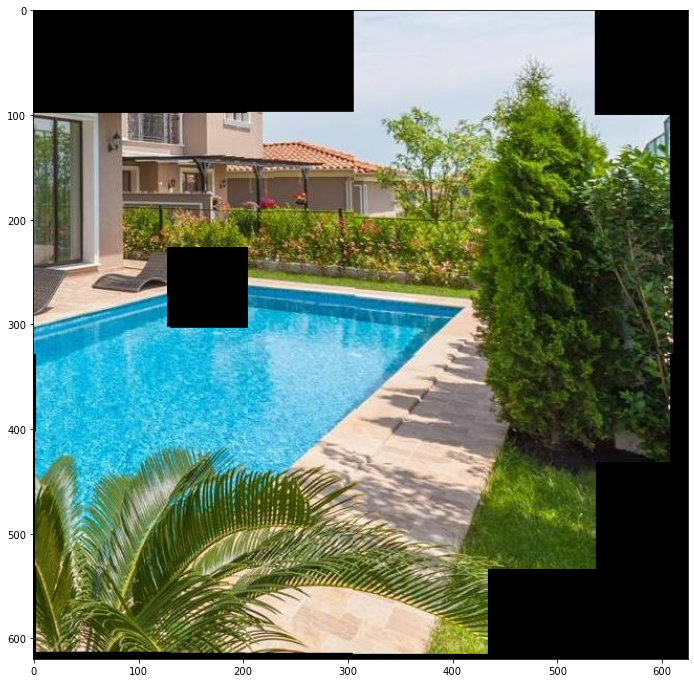

In [358]:
draw(res__)

Этот ноутбук "вырезан" из ноутбука с первой и второй задачами, т.к. исходник слишком большого размера. 
Какие-то части кода могут не воспроизводиться правильно. Рекомендуем скачать [общий ноутбук](https://drive.google.com/file/d/11WhYM1wVJPWnsI7sFR0aMzPewrySuxH_/view?usp=sharing).